In [1]:
import os
import ast
import sys
src_dir = os.path.join('..', 'src')
sys.path.append(os.path.abspath(src_dir))
import numpy as np
import tensorflow as tf

from embbeding import get_embbeding_layer
from vectorizer import load_vectorizer
from data import get_dataset
from dataprep import split, preprocess

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = get_dataset()
data.is_oc = data.is_oc.astype(np.float32)
data.is_self = data.is_self.astype(np.float32)
train, test = split(data)
train, test = preprocess(train, test)

../../data/datasets/data_0.99.csv


In [3]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("score")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    
    return ds
    
train_ds = dataframe_to_dataset(train)
validation_ds = dataframe_to_dataset(test)

In [4]:
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)

In [5]:
def encode_text_feature(feature, name, dataset):
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100, output_mode='int')

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    vectorizer.adapt(feature_ds)
    encoded_feature = vectorizer(feature)
    
    return encoded_feature

In [6]:
def embbed_vectorized_text(feature):
    return layers.Embedding(20000, 64)(feature)

In [7]:
def text_input(columns):
    return [keras.Input(shape=(1,), name=column, dtype=tf.string) for column in columns]

def numerical_input(columns):
    return [keras.Input(shape=(1,), name=column, dtype="float64") for column in columns]

def vectorize_inputs(input_layers, columns, dataset):
    result = []
    for i, layer in enumerate(input_layers):
        result.append(encode_text_feature(layer, columns[i], dataset))
        
    return result

def embedding_layers(in_layers):
    return [embbed_vectorized_text(layer) for layer in in_layers]

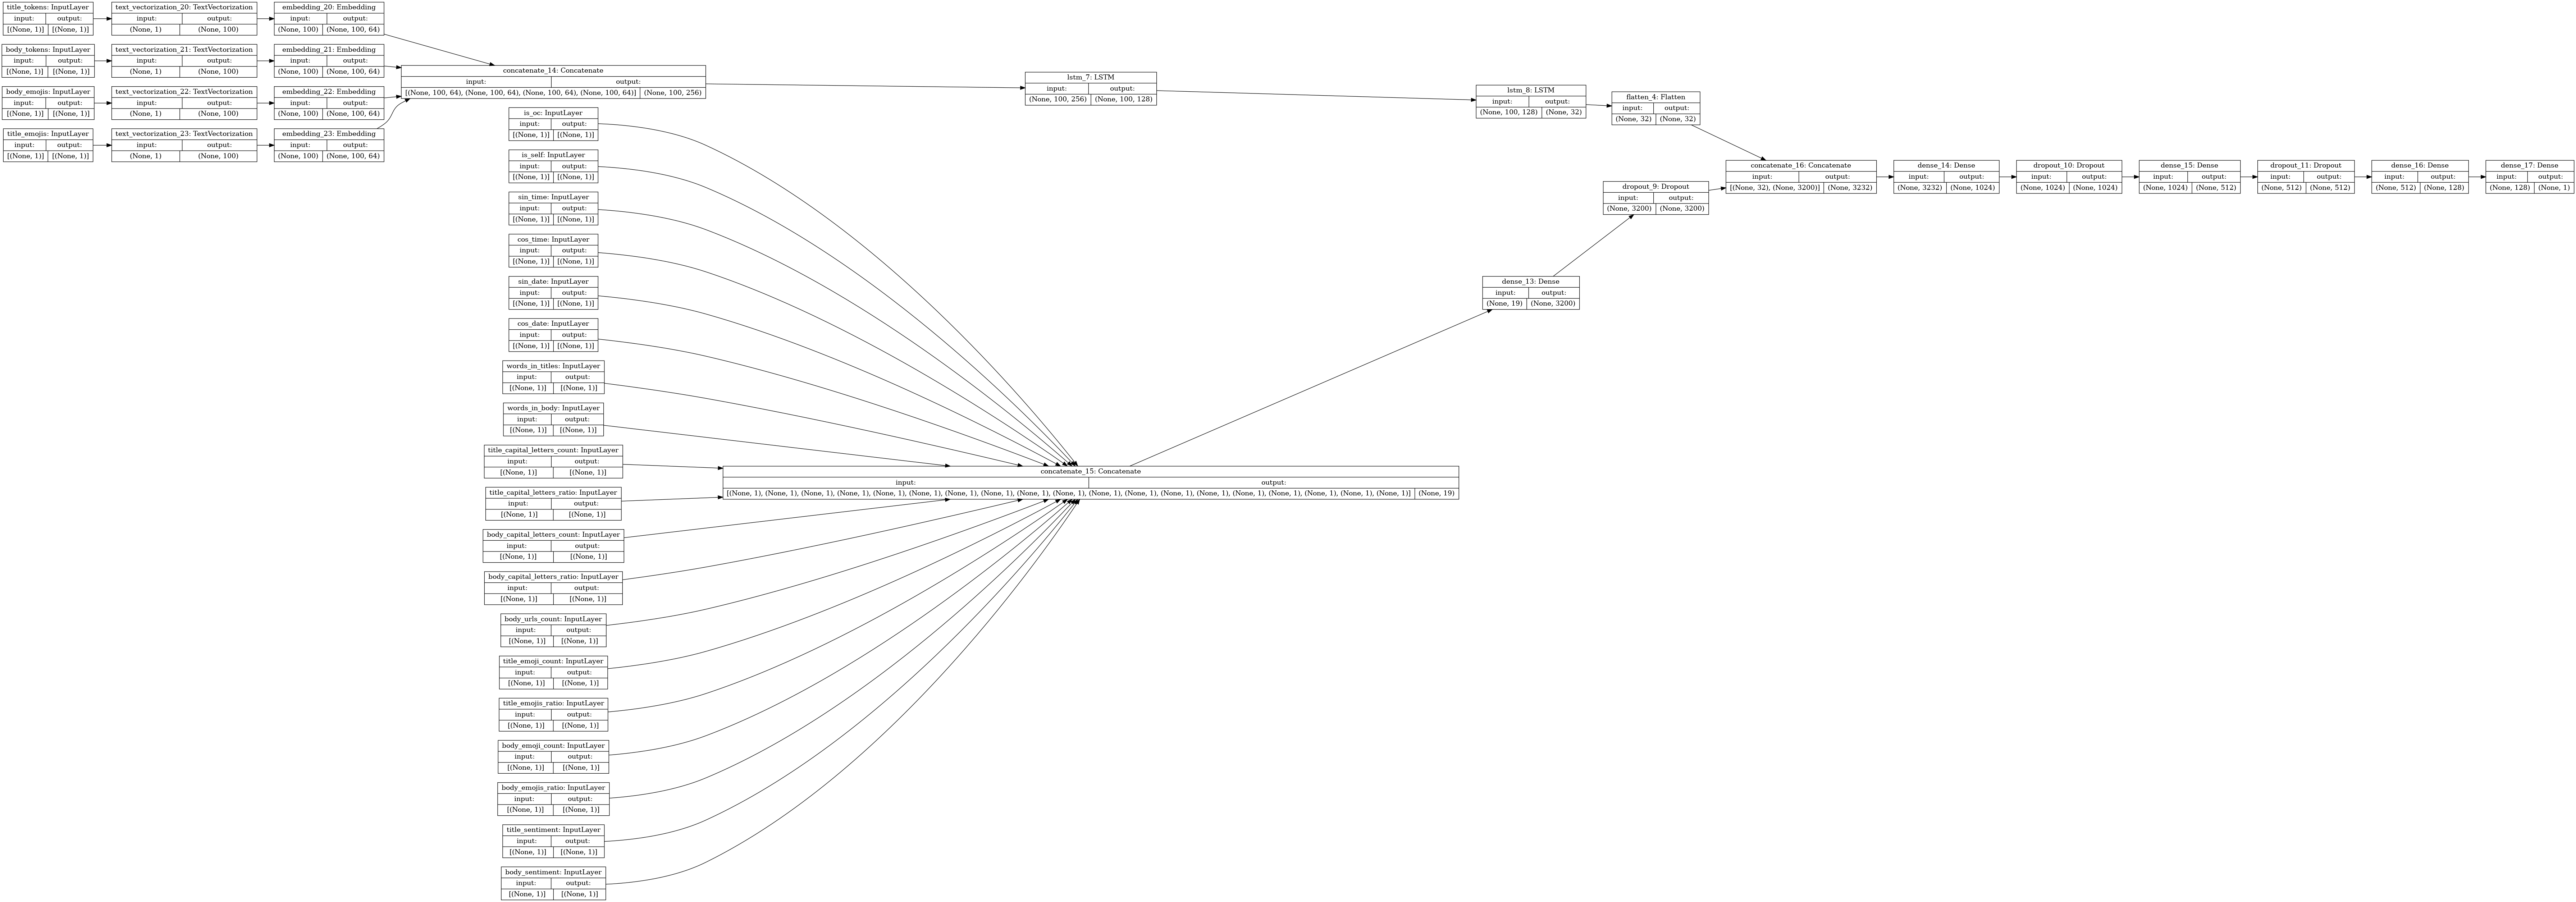

In [13]:
text_columns = train.iloc[:, 1:5].columns
numerical_columns = train.iloc[:, 5:].columns

text_inputs = text_input(text_columns)
numerical_inputs = numerical_input(numerical_columns)
all_inputs = text_inputs + numerical_inputs

vectorized_text_layers = vectorize_inputs(text_inputs, text_columns, train_ds)
embedded_text_layers = embedding_layers(vectorized_text_layers)
text = layers.concatenate(embedded_text_layers)

numerical = layers.concatenate(numerical_inputs)

y = layers.LSTM(128, return_sequences=True)(text)
y = layers.LSTM(32)(y)
y = layers.Flatten()(y)

x = layers.Dense(3200, activation="relu")(numerical)
x = layers.Dropout(0.5)(x)

all_ = layers.concatenate([y, x])
z = layers.Dense(1024, activation="relu")(all_)
z = layers.Dropout(0.5)(z)
z = layers.Dense(512, activation="relu")(z)
z = layers.Dropout(0.2)(z)
z = layers.Dense(128, activation="relu")(z)

output = layers.Dense(1, activation="linear")(z)
model = keras.Model(all_inputs, output)
model.compile("adam", loss="mean_absolute_error")
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [14]:
model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
1095/1095 [==============================] - 158s 141ms/step - loss: 966.0001 - val_loss: 1193.4124
Epoch 2/50
1095/1095 [==============================] - 148s 135ms/step - loss: 962.3309 - val_loss: 1195.2479
Epoch 3/50
1095/1095 [==============================] - 150s 137ms/step - loss: 961.5284 - val_loss: 1192.5265
Epoch 4/50
1095/1095 [==============================] - 142s 130ms/step - loss: 960.4430 - val_loss: 1193.1964
Epoch 5/50
1095/1095 [==============================] - 152s 139ms/step - loss: 958.6501 - val_loss: 1192.0250
Epoch 6/50
1095/1095 [==============================] - 144s 131ms/step - loss: 956.6829 - val_loss: 1194.3594
Epoch 7/50
1095/1095 [==============================] - 140s 128ms/step - loss: 955.5618 - val_loss: 1192.1022
Epoch 8/50
1095/1095 [==============================] - 141s 128ms/step - loss: 952.7602 - val_loss: 1192.2966
Epoch 9/50
1095/1095 [==============================] - 140s 128ms/step - loss: 951.0413 - val_loss: 1196.1903
E